In [1]:
import sys
import os
import pandas
import numpy as np
import uproot
import math
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.stats.proportion import proportion_confint
from scipy import interpolate
sys.path.insert(0, "../../python")
from common import *

In [19]:
class DiscriminatorWP:
    VVVLoose = 0
    VVLoose = 1
    VLoose = 2
    Loose = 3
    Medium = 4
    Tight = 5
    VTight = 6
    VVTight = 7
    VVVTight = 8
    
    @staticmethod
    def GetName(wp):
        names = [ "VVVLoose", "VVLoose", "VLoose", "Loose", "Medium", "Tight", "VTight", "VVTight", "VVVTight" ]
        return names[wp]

class RocCurve:
    def __init__(self, n_points, color, has_errors):
        self.pr = np.zeros((2, n_points))
        self.color = color
        if has_errors:
            self.pr_err = np.zeros((2, 2, n_points))
        else:
            self.pr_err = None
        self.ratio = None
        self.thresholds = None
        self.auc_score = None

    def Draw(self, ax, ax_ratio = None):
        if self.pr_err is not None:
            ax.errorbar(self.pr[1], self.pr[0], xerr=self.pr_err[1], yerr=self.pr_err[0], color=self.color,
                        fmt='--o', markersize='3', linewidth=1)
        else:
            ax.errorbar(self.pr[1], self.pr[0], color=self.color)
        if self.ratio is not None and ax_ratio is not None:
            ax_ratio.plot(self.ratio[1], self.ratio[0], color=self.color, linewidth=1)

class PlotSetup:
    def __init__(self, xlim = None, ylim = None, ratio_ylim = None, ylabel = None):
        self.xlim = xlim
        self.ylim = ylim
        self.ratio_ylim = ratio_ylim
        self.ylabel = ylabel

    def Apply(self, names, ax, ax_ratio = None):
        if self.xlim is not None:
            ax.set_xlim(self.xlim)
        if self.ylim is not None:
            ax.set_ylim(self.ylim)

        ax.set_yscale('log')
        ax.set_ylabel(self.ylabel, fontsize=16)
        ax.tick_params(labelsize=14)
        ax.grid(True)
        ax.legend(names, fontsize=14, loc='upper left')

        if ax_ratio is not None:
            if self.ratio_ylim is not None:
                ax_ratio.set_ylim(self.ratio_ylim)

            ax_ratio.set_xlabel('Tau ID efficiency', fontsize=16)
            ax_ratio.set_ylabel('id/deepId', fontsize=14)
            ax_ratio.tick_params(labelsize=10)

            ax_ratio.grid(True)

def find_threshold(pr, thresholds, target_pr):
    min_delta_index = 0
    min_delta = abs(pr[0] - target_pr)
    for n in range(len(pr)):
        delta = abs(pr[n] - target_pr)
        if delta < min_delta:
            min_delta = delta
            min_delta_index = n
    if min_delta > 0.01:
        return None
    return thresholds[min_delta_index]

class Discriminator:
    def __init__(self, name, column, raw, from_tuple, color, working_points = []):
        self.name = name
        self.column = column
        self.raw = raw
        self.from_tuple = from_tuple
        self.color = color
        self.working_points = working_points

    def CountPassed(self, df, wp):
        flag = 1 << wp
        return np.count_nonzero(np.bitwise_and(df[self.column], flag))

    def CreateRocCurve(self, df, ref_roc = None):
        if self.raw:
            fpr, tpr, thresholds = metrics.roc_curve(df['gen_tau'].values, df[self.column].values)
            roc = RocCurve(len(fpr), self.color, False)
            roc.pr[0, :] = fpr
            roc.pr[1, :] = tpr
            roc.thresholds = thresholds
            roc.auc_score = metrics.roc_auc_score(df['gen_tau'].values, df[self.column].values)
        else:
            n_wp = len(self.working_points)
            roc = RocCurve(n_wp, self.color, True)
            for n in range(n_wp):
                for kind in [0, 1]:
                    df_x = df[df['gen_tau'] == kind]
                    n_passed = self.CountPassed(df_x, self.working_points[n])
                    n_total = df_x.shape[0]
                    ci_low, ci_upp = proportion_confint(n_passed, n_total, alpha=1-0.68, method='beta')
                    eff = float(n_passed) / n_total
                    roc.pr[kind, n_wp - n - 1] = eff
                    roc.pr_err[kind, 1, n_wp - n - 1] = ci_upp - eff
                    roc.pr_err[kind, 0, n_wp - n - 1] = eff - ci_low
        if ref_roc is not None:
            roc.ratio = create_roc_ratio(roc.pr[1], roc.pr[0], ref_roc.pr[1], ref_roc.pr[0])

        return roc

def ReadBrancesToDataFrame(file_name, tree_name, branches):
    if file_name.endswith('.root'):
        with uproot.open(file_name) as file:
            tree = file[tree_name]
            df = tree.arrays(branches, outputtype=pandas.DataFrame)
        return df
    elif file_name.endswith('.h5') or file_name.endswith('.hdf5'):
        return pandas.read_hdf(file_name, tree_name, columns=branches)
    raise RuntimeError("Unsupported file type.")

core_branches = [ 'tau_pt', 'tau_decayModeFinding', 'tau_decayMode', 'gen_tau', 'againstElectronMVA6',
                  'againstMuon3', 'byIsolationMVArun2017v2DBoldDMwLT2017' ]

all_discriminators = {
    'e': [
        Discriminator('MVA6', 'againstElectronMVA6', False, True, 'green',
                      [ DiscriminatorWP.VLoose, DiscriminatorWP.Loose, DiscriminatorWP.Medium, DiscriminatorWP.Tight,
                        DiscriminatorWP.VTight ] ),
        Discriminator('MVA6 2018', 'againstElectronMVA62018', False, True, 'red',
                      [ DiscriminatorWP.VLoose, DiscriminatorWP.Loose, DiscriminatorWP.Medium, DiscriminatorWP.Tight,
                        DiscriminatorWP.VTight ] ),
        Discriminator('deepTau 2017v1', 'byDeepTau2017v1VSeraw', True, True, 'blue'),
        Discriminator('new deepTau', 'deepId_vs_e', True, False, 'yellow')
    ],
    'mu': [
        Discriminator('againstMuon3', 'againstMuon3', False, True, 'green',
                      [ DiscriminatorWP.Loose, DiscriminatorWP.Tight] ),
        Discriminator('deepTau 2017v1', 'byDeepTau2017v1VSmuraw', True, True, 'blue'),
        Discriminator('new deepTau', 'deepId_vs_mu', True, False, 'yellow')
    ],
    'jet': [
        Discriminator('MVA 2017v2', 'byIsolationMVArun2017v2DBoldDMwLT2017raw', True, True, 'green'),
        Discriminator('MVA 2017v2 newDM', 'byIsolationMVArun2017v2DBnewDMwLT2017raw', True, True, 'red'),
        Discriminator('DPF 2016v0', 'byDpfTau2016v0VSallraw', True, True, 'magenta'),
        Discriminator('deepTau 2017v1', 'byDeepTau2017v1VSjetraw', True, True, 'blue'),
        Discriminator('new deepTau', 'deepId_vs_jet', True, False, 'yellow')
    ]
}

plot_setups = {
    'e': PlotSetup(xlim=[0.4, 1], ratio_ylim=[0, 2], ylabel='Electron mis-id probability'),
    'mu': PlotSetup(xlim=[0.9, 1], ratio_ylim=[0, 2], ylabel='Muon mis-id probability'),
    'jet': PlotSetup(xlim=[0.2, 1], ratio_ylim=[0, 2], ylabel='Jet mis-id probability')
}

In [16]:
input_taus = '../../../../output/tuples-v2-t2/testing/tau_HTT.h5'
#input_other = '../../../../output/tuples-v2-t2/testing/e_DY.h5'
#input_other = '../../../../output/tuples-v2-t2/testing/mu_DY.h5'
#input_other = '../../../../output/tuples-v2-t2/testing/jet_QCD.h5'
input_other = '../../../../output/tuples-v2-t2/testing/jet_TT.h5'
deep_results = '../../../../output/predictions/2017v2p5/step1_epoch0'
other_type = 'jet'

In [17]:
discriminators = all_discriminators[other_type]
all_branches = core_branches + [ disc.column for disc in discriminators if disc.from_tuple == True ]

In [18]:
df_jets = ReadBrancesToDataFrame(input_other, 'taus', all_branches)

In [5]:
def CreateDF(file_name):
    df = ReadBrancesToDataFrame(file_name, 'taus', all_branches)
    base_name = os.path.basename(file_name)
    pred_file_name = os.path.splitext(base_name)[0] + '_pred.h5'
    df_pred = pandas.read_hdf(os.path.join(deep_results, pred_file_name))
    #tau_vs_other = - df_pred['deepId_' + args.other_type].values
    #tau_vs_other = df_pred['deepId_tau'].values / (df_pred['deepId_tau'].values \
    #                                               + df_pred['deepId_' + other_type].values + TauLosses.epsilon)
    #tau_vs_other = TauLosses.tau_vs_other(df_pred['deepId_tau'].values, df_pred['deepId_' + other_type].values)
    #tau_vs_other = df_pred['deepId_tau'].values
    #tau_vs_other = -df_pred['deepId_' + args.other_type].values
    #tau_vs_other = tau_vs_other * (df_pred['deepId_tau'].values > 0.15) + \
    #                df_pred['deepId_tau'].values * (df_pred['deepId_tau'].values <= 0.15)
    #df['deepId_vs_' + other_type] = pandas.Series(tau_vs_other, index=df.index)
    #df['deepId_tau'] = pandas.Series(df_pred['deepId_tau'].values, index=df.index)
    #df['deepId_' + other_type] = pandas.Series(df_pred['deepId_' + other_type].values, index=df.index)
    #df['tau_pt'] = pandas.Series(df.tau_pt *(1000 - 20) + 20, index=df.index)
    for out in match_suffixes:
        if out != 'tau':
            tau_vs_other = TauLosses.tau_vs_other(df_pred['deepId_tau'].values, df_pred['deepId_' + out].values)
            df['deepId_vs_' + out] = pandas.Series(tau_vs_other, index=df.index)
        df['deepId_' + out] = pandas.Series(df_pred['deepId_' + out].values, index=df.index)

    return df

df_taus = CreateDF(input_taus)
#df_other = CreateDF(input_other)
#df_all = df_taus.append(df_other)

In [6]:
if other_type == 'e':
    df_all = df_all[ \
        (np.bitwise_and(df_all['byIsolationMVArun2017v2DBoldDMwLT2017'], 1 << DiscriminatorWP.VVLoose) > 0) \
        & (np.bitwise_and(df_all['againstMuon3'], 1 << DiscriminatorWP.Loose) > 0) \
        & (df_all['tau_decayMode'] != 5) & (df_all['tau_decayMode'] != 6) ]
    # df_all = df_all[ \
    #     (np.bitwise_and(df_all['byIsolationMVArun2017v2DBoldDMwLT2017'], 1 << DiscriminatorWP.Medium) > 0) \
    #     & (np.bitwise_and(df_all['againstMuon3'], 1 << DiscriminatorWP.Loose) > 0) \
    #     & (df_all['tau_decayMode'] != 5) & (df_all['tau_decayMode'] != 6) ]

    #df_all = df_all[(df_all['tau_decayMode'] != 5) & (df_all['tau_decayMode'] != 6) ]
elif other_type == 'mu':
    df_all = df_all[ \
        (np.bitwise_and(df_all['byIsolationMVArun2017v2DBoldDMwLT2017'], 1 << DiscriminatorWP.VVLoose) > 0) \
        & (np.bitwise_and(df_all['againstElectronMVA6'], 1 << DiscriminatorWP.VLoose) > 0) \
        & (df_all['tau_decayMode'] != 5) & (df_all['tau_decayMode'] != 6) ]
elif other_type == 'jet':
    df_all = df_all[ (np.bitwise_and(df_all['againstElectronMVA6'], 1 << DiscriminatorWP.VLoose) > 0) \
                     & (np.bitwise_and(df_all['againstMuon3'], 1 << DiscriminatorWP.Loose) > 0) \
                     & (df_all['tau_decayMode'] != 5) & (df_all['tau_decayMode'] != 6) ]

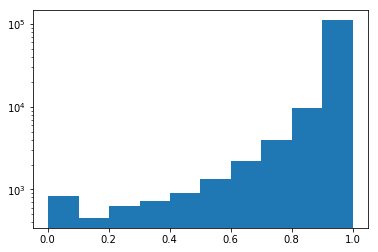

In [16]:
plt.hist(df_all[(df_all.gen_tau == 1) & (df_all.tau_pt < 30)].deepId_tau)
plt.yscale('log')
plt.savefig('deepId_tau.pdf')

In [14]:
df_all[(df_all.gen_tau == 1) & (df_all.deepId_tau > 0.10)].shape[0] / \
    df_all[(df_all.gen_tau == 1)].shape[0]

0.9930674059829895

In [26]:
df_all[(df_all.gen_tau == 0) & (df_all.tau_pt < 30)].shape

(160000, 14)

In [27]:
14271 / 160000

0.08919375

In [21]:
np.average(-np.log(df_all[(df_all.gen_tau == 1) & (df_all.tau_pt > 100) & (df_all.tau_pt < 300) \
               & (df_all.deepId_tau < 1)].deepId_tau))

0.18015593

In [26]:
df_taus = CreateDF(input_taus)

In [27]:
np.average(-np.log(df_taus[df_taus.tau_pt < 30].deepId_tau))

0.40663317

In [28]:
df_taus[df_taus.deepId_tau < 0.1].shape[0] / df_taus.shape[0]

0.01074368178686682

In [30]:
math.exp(-0.40)

0.6703200460356393

In [11]:
-np.average(np.log(df_all[(df_all.gen_tau == 1) & (df_all.tau_pt < 30)].deepId_vs_e)) \
-np.average(np.log(1 - df_all[(df_all.gen_tau == 0) & (df_all.tau_pt < 30)].deepId_vs_e))

4.5749817

In [12]:
-np.average(np.log(df_all[(df_all.gen_tau == 1) & (df_all.tau_pt < 30)].byDeepTau2017v1VSeraw)) \
-np.average(np.log(1 - df_all[(df_all.gen_tau == 0) & (df_all.tau_pt < 30)].byDeepTau2017v1VSeraw))

5.267838

In [15]:
for dm in [0, 1, 2, 5, 6, 10, 11]:
    print(dm, df_taus[df_taus.tau_decayMode == dm].shape[0], \
          df_taus[(df_taus.tau_decayModeFinding == 1) & (df_taus.tau_decayMode == dm)].shape[0])

0 204470 204470
1 336995 336995
2 0 0
5 41632 0
6 17389 0
10 161137 138740
11 65747 0


In [14]:
161137/138740

1.1614314545192446

In [32]:
dm = 10
df = df_jets
print("{:<10}{:<17}{:<17}{:<17}{:<17}".format('wp', 'n_jets (old DM)', 'n_jets (new DM)',
                                              'n_taus (old DM)', 'n_taus (new DM)'))
for wp in [ None, DiscriminatorWP.VLoose, DiscriminatorWP.Loose, DiscriminatorWP.Medium, DiscriminatorWP.Tight,
                        DiscriminatorWP.VTight ]:
    if wp is not None:
        pre_sel_jet = (df_jets.tau_decayMode == dm) & \
                  (np.bitwise_and(df_jets['byIsolationMVArun2017v2DBoldDMwLT2017'], 1 << wp) > 0)
        pre_sel_tau = (df_taus.tau_decayMode == dm) & \
          (np.bitwise_and(df_taus['byIsolationMVArun2017v2DBoldDMwLT2017'], 1 << wp) > 0)
        wp_name = DiscriminatorWP.GetName(wp)
    else:
        pre_sel_jet = (df_jets.tau_decayMode == dm)
        pre_sel_tau = (df_taus.tau_decayMode == dm)
        wp_name = "None"
    n_jet_new = df_jets[pre_sel_jet].shape[0]
    n_jet_old = df_jets[pre_sel_jet & (df_jets.tau_decayModeFinding == 1)].shape[0]
    n_tau_new = df_taus[pre_sel_tau].shape[0]
    n_tau_old = df_taus[pre_sel_tau & (df_taus.tau_decayModeFinding == 1)].shape[0]
    print("{:<10}{:<17}{:<17}{:<17}{:<17}".format(wp_name, n_jet_old, n_jet_new, n_tau_old, n_tau_new))

wp        n_jets (old DM)  n_jets (new DM)  n_taus (old DM)  n_taus (new DM)  
None      495904           537093           138740           161137           
VLoose    8839             10837            119833           137821           
Loose     3752             4671             106014           120535           
Medium    2058             2514             92778            103989           
Tight     1184             1438             80288            88881            
VTight    696              845              68291            74808            
